# Fathers Share of Parential Leave 

Imports and set magics:

In [1]:
# a. import packeges  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydst
import ipywidgets as widgets
import matplotlib.ticker as ticker

# b. define Danish Statistics API as dst 
dst = pydst.Dst(lang='en')

# c. autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# d. plotting style 
plt.style.use('seaborn-whitegrid')

# e. user written modules
import dataproject as data 

In [2]:
# set the default format for the x-axis labels to 'YYYY'
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['axes.formatter.limits'] = (-4, 4)
plt.rcParams['axes.formatter.min_exponent'] = 0
plt.rcParams['axes.formatter.use_locale'] = True
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['date.autoformatter.year'] = '%Y'

## Introduction

Due to the new regulations on parential leave in Denmark in 2022, where fathers got 11 earmarked weeks, we want to look at fathers share of the parential leave. But given that there is no data on the effect jet, we look at data from before the regulation.

Further, we look at how education for the mother and the farther effects the fathers share for the first year of a child's life. 

To do so, we look at BARSEL05 from Danish Statistics and we choose parents which both are entitled to Danish parential leave benefits. This is due to the more streamlined estimate, and there is great amount of data. The data contains the number of couples and avearge days on parential leave for mother and father.
The data countains data from 2015 - 2021. 

## Load parential leave data

We load BARSEL05 from Danish statisics. Where we want to pic the different variables: TAL, ids, BERET, MORUD, FARUD, OMRÅDE. 

For TAL we want to look at:

- "Number of couples", 
- "Mother - days on parental leave (benefits) before birth on average", 
- "Mother - days on parental leave (benefits) after birth on average" and 
- "Father - days on parental leave (benefits) after birth on average"

So we pic the ids 000, 202, 220 and 330. 

For BERET we want "Both mother and father are entitled to parental leave". This is 511.

For MORUD and FARUD we want all education levels and for Tid we want all obervation years (2015 - 2021). 

For OMRÅDE we want "All Denmark" so we pic id 000. 


In [3]:
# a. load the data
barsel = dst.get_data(table_id = 'BARSEL05', 
                      variables={'TAL':['000','202','220','330'], 
                                 'BERET':['511'], 
                                 'MORUD':['*'], 
                                 'FARUD':['*'], 
                                 'OMRÅDE':['000'], 
                                 'Tid':['*']})

In order to make it more convenient, we rename the columns to contain english names.

In [4]:
# a. define new column names 
eng = {
    'TAL'    : 'Numb',
    'BERET'  : 'Entitle',
    'MORUD'  : 'Mom_educ',
    'FARUD'  : 'Dad_educ',
    'OMRÅDE' : 'Area',
    'TID'    : 'Year',
    'INDHOLD': 'Count'
}

# b. rename columns 
barsel = barsel.rename(columns = eng)

# c. copy 'barsel' to have the original 
barsel_true = barsel.copy()

# d. set Year as an integer 
barsel_true['Year'] = barsel_true['Year'].astype(int)

# e. Sets Count as a float 
barsel_true['Count'] = barsel_true['Count'].astype(float)

## Data processing, figures and tables 

We can start by looking at the number of couples over time to make sure we have a proper amount. To do so, we look at "Number of couples" in total.

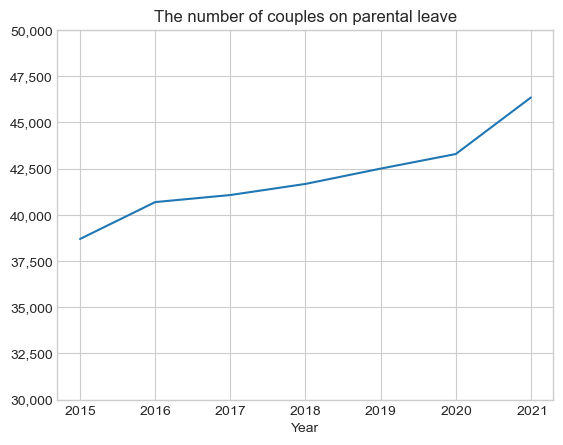

In [5]:
# a. extract the number of couples in total
number = data.numb_parent(barsel_true)

# b. plot the number of couples in total
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(number['Year'], number['Count'], '-')
ax.set_ylim(30000, 50000)
ax.set_xlabel('Year')
ax.set_title('The number of couples on parental leave');
# i. set the y-axis to show the numbers in thousands
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: format(int(y), ',')))

From the above plot it is seen that there a plenty of data in each year. So, we carry the analysis forward. 

Now, we wants to look the average days of parential leave for mother and father. Thus, we extract "All fathers, regardless of education" for dad_educ, "All mothers, regardless of education" for mom_educ and "Mother - days on parental leave (benefits) after birth on average" for Numb for mother and "Father - days on parental leave (benefits) after birth on average" for Numb for father. 

We save the values for the mother in 'Mother_all' and for the father in 'Father_all'. We cut both datasets such it only contains Year and Count. 

In [6]:
# Extract Father_all and Mother_all from the 'extract_data' function 
Mother_all, Father_all = data.extract_data(barsel_true)

Then we want to plot the two datasets against each other. This is presented in the following interactive plot - one can pic mother or farther. 

In [7]:
# a. define the ToggleButtons widget
options = ['Mother (after birth)', 'Father']
toggle_buttons = widgets.ToggleButtons(options=options, description='Parent:')

# b. function to update the plot
def update_plot(dataset):
    fig, ax = plt.subplots(figsize=(8, 5)) 
    # i. plot mother 
    if dataset == 'Mother (after birth)':
        ax.plot(Mother_all['Year'], Mother_all['Count'])
        ax.set_ylim(275, 285)
        ax.set_title('Average days of parental leave for mother')
        ax.set_ylabel('Days')
        ax.set_xlabel('Year')
    # ii. plot father 
    elif dataset == 'Father':
        ax.plot(Father_all['Year'], Father_all['Count'])
        ax.set_ylim(28, 38)
        ax.set_title('Average days of parental leave for father')
        ax.set_ylabel('Days')
        ax.set_xlabel('Year')
    
# c. connect the ToggleButtons widget to the update function
widgets.interactive(update_plot, dataset=toggle_buttons)

interactive(children=(ToggleButtons(description='Parent:', options=('Mother (after birth)', 'Father'), value='…

From the above we see that the average days for the mother after the birth as a bit decreasing from 282,8 in 2015 to 278 in 2021. For the father the average days of parential leave is increasing from 29,7 in 2015 to 35.6 in 2021. 

Next, we want to look at the elaboration of the fathers share of parential leave on average. We can do this with the data from the above plot. We merge and find the father's part of the total parential leave. 

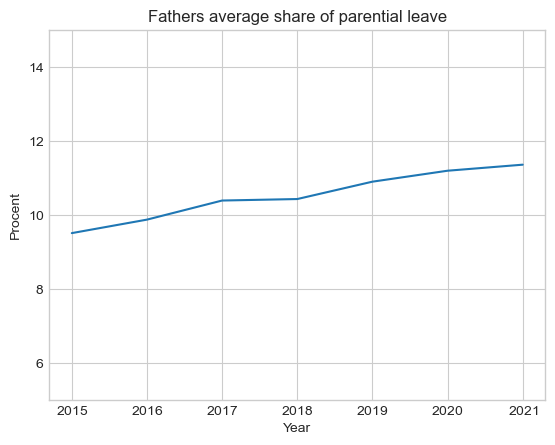

In [8]:
# a. Copy the dataframe 'Father_all'
Father_part = Father_all.copy()

# b. Left merge 'Father_part' and 'Mother_all' on TID 
Father_part = pd.merge(Father_part, Mother_all, how = 'left', on = 'Year')

# c. Rename the columns 
Father_part.columns = ['Year', 'father', 'mother']

# d. Find the father's part 
Father_part['Count'] = Father_part['father']/(Father_part['father'] + Father_part['mother'])*100

# e. Define figure and ax 
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# f. Plot father's part 
Father_part.plot(x = 'Year', y = 'Count', ax=ax)

# g. Set title, label, y-axis limits and removes the legend
ax.set_title('Fathers average share of parential leave')
ax.set_ylabel('Procent')
ax.set_xlabel('Year')
ax.set_ylim(5, 15)
ax.legend().remove()

From the above table it is seen that father's share of parential is increasing from 2015 to 2021. 

Next, we want to see how parential leave distribute when education is included. To do so we set the other parent's education level constant and we cut the data such that it contains the education levels for the father, Year and Count. 

In [9]:
# Extract Father_educ and Mother_educ from the 'manipulate_data' function 
Father_educ, Mother_educ = data.cut_data(barsel_true)

We want to plot the two plots. 

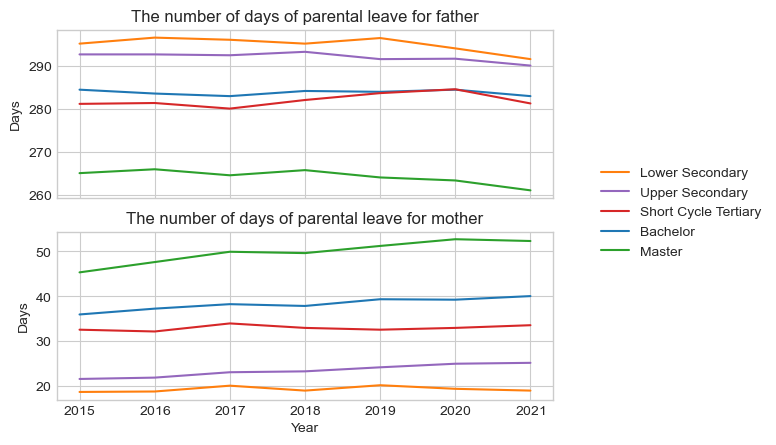

In [10]:
# Extract fig from the 'plot_parental_leave' function using Father_educ and Mother_educ
fig = data.plot_parental_leave(Father_educ, Mother_educ)
plt.show()

Pay attention to the values of the days in the y-axis.

The first above figure shows that the father's number of maternity days is dependent on education level. It can be seen that fathers with lower secondary take the least leave with an average of approximately 20 days. This has almostremained unchanged throughout the observation period. In contrast to this, fathers with a master are seen, where the number of maternity days has increased from around 45 days in 2015 to around 52 days in 2021. Between these two extremes are upper secondary, short cycle tertiary and bachelor, where the number of days increases in line with the level of education.

It is not only fathers' allocation that depends on education level - the same applies to mothers. The second figure shows the mother's maternity leave days divided by education. Here it appears that mothers with lower secondary take the most maternity leave with around 295 days, which is approximately constant from 2015 to 2021. Mothers with upper secondary are just behind with around 292 days. In contrast to father, bachelor is slightly higher than short cycle tertiary in 2015, while they meet at around 285 days in 2021. Master level is seen a bit lower, at around 265 days.

We want to look futher into how the education level of each parent affects the father's share of the parential leave.
The following code prepares the data in 2021.

In [11]:
# Extract the fathers part of parential leave in procent and days from 'calculate_father_share' function
Father_part_educ_2021_pivot_procent, Father_part_educ_2021_pivot_days = data.calculate_father_share(barsel_true, 2021)

Then we present the conditional share of parential leave for the father. 

First in percent: 

In [12]:
print('Fathers share of the parential leave depending on education level in %')
Father_part_educ_2021_pivot_procent

Fathers share of the parential leave depending on education level in %


Dad_educ,Lower Secondary,Upper Secondary,Short Cycle Tertiary,Bachelor,Master
Mom_educ,,,,,
Lower Secondary,4.9,6.9,8.9,9.3,10.5
Upper Secondary,5.5,6.7,8.3,9.9,11.8
Short Cycle Tertiary,7.0,8.4,10.2,10.8,13.6
Bachelor,6.2,8.1,10.1,11.8,13.7
Master,9.4,12.0,14.2,15.6,18.5


Then we see it in days:

In [13]:
print('Fathers share of the parential leave depending on education level in days')
Father_part_educ_2021_pivot_days

Fathers share of the parential leave depending on education level in days


Dad_educ,Lower Secondary,Upper Secondary,Short Cycle Tertiary,Bachelor,Master
Mom_educ,,,,,
Lower Secondary,15.5,21.6,26.4,28.7,32.8
Upper Secondary,17.4,21.0,25.7,31.0,37.0
Short Cycle Tertiary,21.8,26.0,31.7,34.1,42.6
Bachelor,19.5,25.5,32.1,37.4,42.9
Master,29.2,37.3,44.5,48.8,57.8


The tables shows that the father's share of maternity days either weakens or increases depending on the mother's education. If, for example, both mother and father have lower secondary education, the father only takes 14.5 days of maternity leave, which corresponds to 4.9% of the total maternity leave.

The overall average, seen in the second figure, lies between these two levels of education. Conversely, if we look at mothers with a master, it appears that only fathers with lower secondary are below the average from the second figure with 29.2 days. The highest proportion is found where both parents have a master, then the father takes 18.5% of the maternity leave. Thus, there is a 13.6%-point difference between the smallest and largest share.

## Conclusion

From the above analysis it is seen that father's share of parential leave is increasing. Futher, we see that the share is conditional on the education for mother and father. The higher the education for both - the higher the father's share. It is expected to observe further increase when the results of the regulation is observed.